# Train and evaluate DFR on ImageNet-9 variations

In [1]:
import sys
import numpy as np
import torch
import torchvision
import einops
import json
import tqdm

from matplotlib import pyplot as plt

import sys
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
device = torch.device("cuda:6")

learning_rate = 1
num_epochs = 2000

ns = [1000, 5000, 10000, 20000, 45405]
num_seeds = 5

In [3]:
map_to_in9 = {}
with open('in_to_in9.json', 'r') as f:
    map_to_in9.update(json.load(f))

def load_embeddings(path):
    arr = np.load(path)
    x, y = arr["embeddings"], arr["labels"]
    if np.max(y) > 9:
        y = np.array([map_to_in9[str(y_)] for y_ in y])
        mask = y != -1
        x, y = x[mask], y[mask]
    return x, y

In [4]:
def train_logreg(
    x_train, y_train, eval_datasets,
    n_epochs=1000, weight_decay=0., lr=1.,
    verbose=0
    ):
    
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).long().to(device)
    
    d = x_train.shape[1]
    model = torch.nn.Linear(d, 9).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), weight_decay=weight_decay, lr=lr)
    schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        schedule.step()
        acc = (torch.argmax(pred, -1) == y_train).detach().float().mean()
        if verbose > 1 and epoch % (n_epochs // 10) == 0:
            print(epoch, acc)
    
    results = {}
    for key, (x_test, y_test) in eval_datasets.items():
        x_test = torch.from_numpy(x_test).float().to(device)
        pred = torch.argmax(model(x_test), axis=-1).detach().cpu().numpy()
        results[key] = (pred == y_test).mean()
    
    pred = torch.argmax(model(x_train), axis=-1)
    results["train"] = (pred == y_train).detach().cpu().float().mean().item()

    return model, results

def get_data(
    train_datasets, eval_datasets, 
    num_mixrand=-1, num_original=0, preprocess=True):
    
    x_train, y_train = train_datasets["bgc_original"]
    idx = np.arange(len(x_train))
    np.random.shuffle(idx)
    idx = idx[:num_original]
    x_train = x_train[idx]
    y_train = y_train[idx]

    x_train_mr, y_train_mr = train_datasets["bgc_mixedrand"]
    idx = np.arange(len(x_train_mr))
    np.random.shuffle(idx)
    idx = idx[:num_mixrand]
    x_train_mr = x_train_mr[idx]
    y_train_mr = y_train_mr[idx]

    x_train = np.concatenate([x_train, x_train_mr])
    y_train = np.concatenate([y_train, y_train_mr])

    if preprocess:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        eval_datasets_preprocessed = {
            k: (scaler.transform(x), y)
            for k, (x, y) in eval_datasets.items()
        }
    else:
        eval_datasets_preprocessed = eval_datasets
    return x_train, y_train, eval_datasets_preprocessed


def run_experiment(
    train_datasets, eval_datasets,
    num_mixrand=-1, num_original=0, preprocess=True,
    n_epochs=1000, weight_decay=0., lr=1., verbose=0,
    num_seeds=3
):
    print(lr)
    print(weight_decay)
    print(n_epochs)
    results = {}
    for seed in range(num_seeds):
        x_train, y_train, eval_datasets_preprocessed = get_data(
            train_datasets, eval_datasets,
            num_mixrand, num_original, preprocess)
        _, results_seed = train_logreg(
            x_train, y_train, eval_datasets_preprocessed,
            n_epochs, weight_decay, lr, verbose)
        results[seed] = results_seed
    
    results_aggrgated = {
        key: (np.mean([results[seed][key] for seed in results.keys()]),
              np.std([results[seed][key] for seed in results.keys()]))
        for key in results[0].keys()
    }
    return results, results_aggrgated


def print_results(results_dict):
    print("-------------------")
    for key, val in results_dict.items():
        print("{}: {:.3f}±{:.3f}".format(key, val[0], val[1]))
    print("-------------------")

In [5]:
def mixrand_run(ns, n_epochs, lr, train_datasets, eval_datasets, num_seeds):
    mixrand_results_ns = []
    for n in ns:
        num_mixrand = n
        num_original = 0

        n_data = num_mixrand + num_original
        wd = 100 / n_data
        seed_results, results_aggrgated = run_experiment(
            train_datasets, eval_datasets,
            num_mixrand, num_original, lr=lr, weight_decay=wd, n_epochs=n_epochs,
            num_seeds=num_seeds)
        print_results(results_aggrgated)
        mixrand_results_ns.append(results_aggrgated)
    return mixrand_results_ns


def combo_run(ns, n_epochs, lr, train_datasets, eval_datasets, num_seeds):
    combo_results_ns = []
    for n in ns:
        num_mixrand = n
        num_original = n

        n_data = num_mixrand + num_original
        wd = 100 / n_data
        seed_results, results_aggrgated = run_experiment(
            train_datasets, eval_datasets,
            num_mixrand, num_original, lr=lr, weight_decay=wd, n_epochs=n_epochs,
            num_seeds=num_seeds)
        print_results(results_aggrgated)
        combo_results_ns.append(results_aggrgated)
    return combo_results_ns

In [6]:
def plot_results_indv(key, ax, ns, mixrand_results_ns, combo_results_ns, results_original):
    mixrand_mu = np.array([results[key][0] for results in mixrand_results_ns])
    mixrand_sigma = np.array([results[key][1] for results in mixrand_results_ns])

    original_mu = np.array([results_original[key][0] for _ in ns])
    original_sigma = np.array([results_original[key][1] for _ in ns])

    combo_mu = np.array([results[key][0] for results in combo_results_ns])
    combo_sigma = np.array([results[key][1] for results in combo_results_ns])
    ax.plot(ns, mixrand_mu, "-bo", label="DFR MR")
    ax.fill_between(ns, mixrand_mu + mixrand_sigma, mixrand_mu - mixrand_sigma,
                   color="b", alpha=0.3)
    ax.plot(ns, combo_mu, "-ro", label="DFR MR + Og")
    ax.fill_between(ns, combo_mu + combo_sigma, combo_mu - combo_sigma,
                    color="r", alpha=0.3)
    ax.plot(ns, original_mu, "--g", label="DFR Og")
    ax.fill_between(ns, original_mu + original_sigma, original_mu - original_sigma,
                    color="g", alpha=0.3)
    
    ax.legend()
    ax.set_xlabel("# MixedRand Data", fontsize=12)
    ax.set_ylabel(f"{key} Test Acc", fontsize=12)

def plot_all_results_indv(mixrand_results_ns, combo_results_ns, results_original):
    f, arr = plt.subplots(1, 5, figsize=(16, 3))

    plot_results_indv("bgc_mixedrand", arr[0], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("bgc_fg", arr[1], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("bgc_original", arr[2], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("imagenet_r", arr[3], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("imagenet_a", arr[4], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)

    plt.tight_layout()

## Original Network

In [7]:
use_prev_layer = False

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/imagenet-r_{use_prev_layer}_val_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/imagenet-a_{use_prev_layer}_val_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/bg_challenge_{use_prev_layer}_val_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/jennyni/datasets/original/bg_challenge_{use_prev_layer}_train_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/bg_challenge_{use_prev_layer}_train_embeddings.npz",

}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [8]:
# mixrand_results_ns = []
# for n in ns:
#     num_mixrand = n
#     num_original = 0

#     n_data = num_mixrand + num_original
#     wd = 100 / n_data
#     n_epochs = 2000
#     seed_results, results_aggrgated = run_experiment(
#         train_datasets, eval_datasets,
#         num_mixrand, num_original, weight_decay=wd, lr=learning_rate, n_epochs=num_epochs,
#         num_seeds=num_seeds)
#     print_results(results_aggrgated)
#     mixrand_results_ns.append(results_aggrgated)

In [9]:
_, results_original_ori = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_ori)

-------------------
imagenet_r: 0.549±0.000
imagenet_a: 0.377±0.000
bgc_original: 0.978±0.000
bgc_fg: 0.925±0.000
bgc_mixedrand: 0.861±0.000
train: 0.998±0.000
-------------------


In [10]:
mixrand_results_ns_ori = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_ori = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

-------------------
imagenet_r: 0.488±0.017
imagenet_a: 0.270±0.012
bgc_original: 0.935±0.004
bgc_fg: 0.895±0.005
bgc_mixedrand: 0.865±0.004
train: 0.999±0.000
-------------------
-------------------
imagenet_r: 0.517±0.009
imagenet_a: 0.273±0.011
bgc_original: 0.947±0.002
bgc_fg: 0.916±0.005
bgc_mixedrand: 0.897±0.002
train: 0.977±0.002
-------------------
-------------------
imagenet_r: 0.529±0.011
imagenet_a: 0.278±0.011
bgc_original: 0.953±0.003
bgc_fg: 0.927±0.004
bgc_mixedrand: 0.909±0.003
train: 0.955±0.003
-------------------
-------------------
imagenet_r: 0.533±0.012
imagenet_a: 0.285±0.002
bgc_original: 0.958±0.002
bgc_fg: 0.933±0.002
bgc_mixedrand: 0.920±0.002
train: 0.937±0.002
-------------------
-------------------
imagenet_r: 0.554±0.000
imagenet_a: 0.286±0.000
bgc_original: 0.963±0.000
bgc_fg: 0.939±0.000
bgc_mixedrand: 0.926±0.000
train: 0.919±0.000
-------------------
-------------------
imagenet_r: 0.501±0.011
imagenet_a: 0.313±0.014
bgc_original: 0.961±0.001
bgc_fg

In [11]:
def plot_results(key, ax, ns, mixrand_results_ns, combo_results_ns, results_original):
    mixrand_mu = np.array([results[key][0] for results in mixrand_results_ns])
    mixrand_sigma = np.array([results[key][1] for results in mixrand_results_ns])

    original_mu = np.array([results_original[key][0] for _ in ns])
    original_sigma = np.array([results_original[key][1] for _ in ns])

    combo_mu = np.array([results[key][0] for results in combo_results_ns])
    combo_sigma = np.array([results[key][1] for results in combo_results_ns])
    ax.plot(ns, mixrand_mu, "-bo", label="DFR MR")
    ax.fill_between(ns, mixrand_mu + mixrand_sigma, mixrand_mu - mixrand_sigma,
                   color="b", alpha=0.3)
    ax.plot(ns, combo_mu, "-ro", label="DFR MR + Og")
    ax.fill_between(ns, combo_mu + combo_sigma, combo_mu - combo_sigma,
                    color="r", alpha=0.3)
    ax.plot(ns, original_mu, "--g", label="DFR Og")
    ax.fill_between(ns, original_mu + original_sigma, original_mu - original_sigma,
                    color="g", alpha=0.3)
    
    ax.legend()
    ax.set_xlabel("# MixedRand Data", fontsize=12)
    ax.set_ylabel(f"{key} Test Acc", fontsize=12)

In [12]:
print(results_original_ori)

{'imagenet_r': (0.548903465182535, 0.0001992088567995241), 'imagenet_a': (0.3769911504424779, 0.00031273541940709685), 'bgc_original': (0.9783703703703702, 0.0001209624564337682), 'bgc_fg': (0.9253827160493827, 0.00047878319579420435), 'bgc_mixedrand': (0.8609382716049382, 0.0002879482417207494), 'train': (0.9976433515548706, 0.0)}


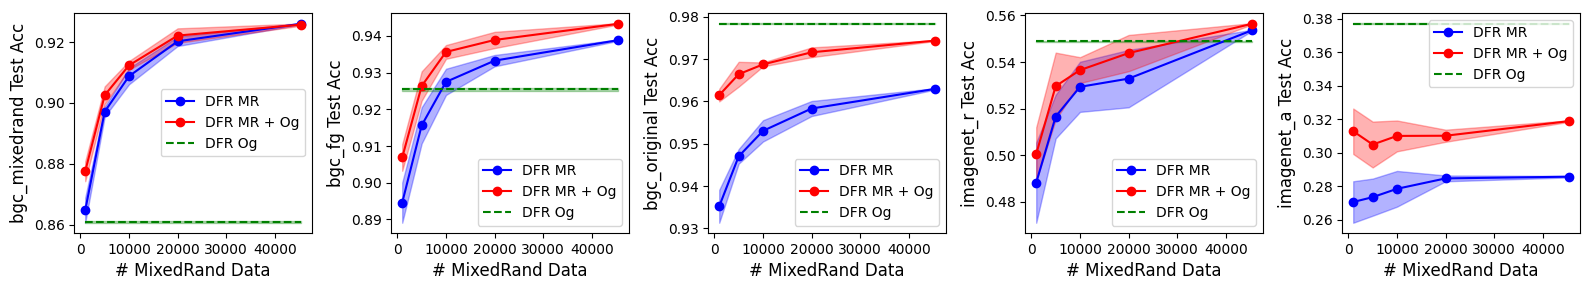

In [13]:
f, arr = plt.subplots(1, 5, figsize=(16, 3))

plot_results("bgc_mixedrand", arr[0], np.array(ns), mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)
plot_results("bgc_fg", arr[1], np.array(ns), mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)
plot_results("bgc_original", arr[2], np.array(ns), mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)
plot_results("imagenet_r", arr[3], np.array(ns), mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)
plot_results("imagenet_a", arr[4], np.array(ns), mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)
# plot_results("bgc_paintings", arr[5], np.array(ns), mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)

plt.tight_layout()

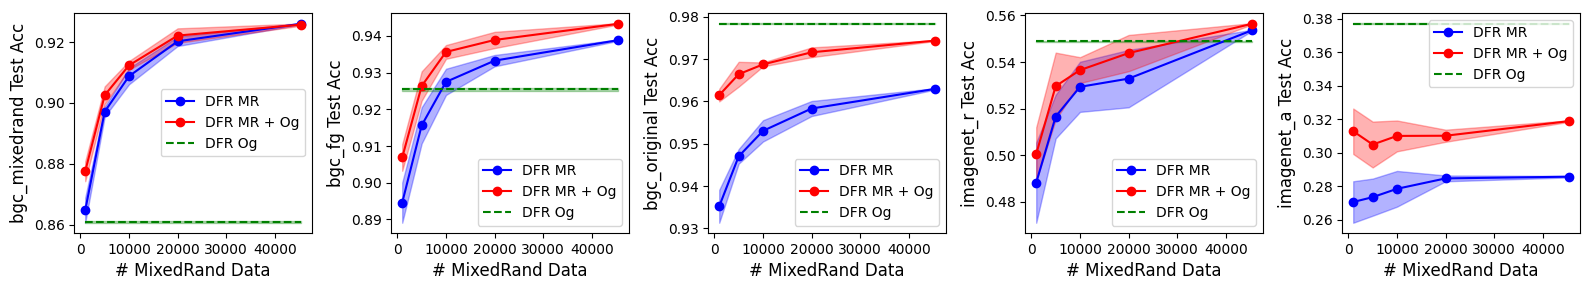

In [14]:
plot_all_results_indv(mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)

## Pre Projection

In [15]:
use_ph = False

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/ph_imagenet-r_{use_ph}_val_standardSL_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/ph_imagenet-a_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/jennyni/datasets/original/ph_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/ph_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [16]:
_, results_original_pre = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_pre)

-------------------
imagenet_r: 0.508±0.000
imagenet_a: 0.352±0.000
bgc_original: 0.968±0.000
bgc_fg: 0.905±0.000
bgc_mixedrand: 0.829±0.000
train: 0.993±0.000
-------------------


In [17]:

mixrand_results_ns_pre = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_pre = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

-------------------
imagenet_r: 0.473±0.022
imagenet_a: 0.252±0.010
bgc_original: 0.901±0.004
bgc_fg: 0.850±0.012
bgc_mixedrand: 0.833±0.005
train: 1.000±0.000
-------------------
-------------------
imagenet_r: 0.502±0.011
imagenet_a: 0.264±0.006
bgc_original: 0.926±0.004
bgc_fg: 0.892±0.006
bgc_mixedrand: 0.873±0.002
train: 0.979±0.001
-------------------
-------------------
imagenet_r: 0.521±0.010
imagenet_a: 0.267±0.007
bgc_original: 0.936±0.004
bgc_fg: 0.898±0.012
bgc_mixedrand: 0.888±0.001
train: 0.959±0.002
-------------------
-------------------
imagenet_r: 0.531±0.004
imagenet_a: 0.277±0.009
bgc_original: 0.941±0.002
bgc_fg: 0.903±0.005
bgc_mixedrand: 0.899±0.003
train: 0.936±0.001
-------------------
-------------------
imagenet_r: 0.540±0.000
imagenet_a: 0.285±0.000
bgc_original: 0.945±0.000
bgc_fg: 0.914±0.000
bgc_mixedrand: 0.906±0.000
train: 0.907±0.000
-------------------
-------------------
imagenet_r: 0.488±0.012
imagenet_a: 0.295±0.015
bgc_original: 0.940±0.002
bgc_fg

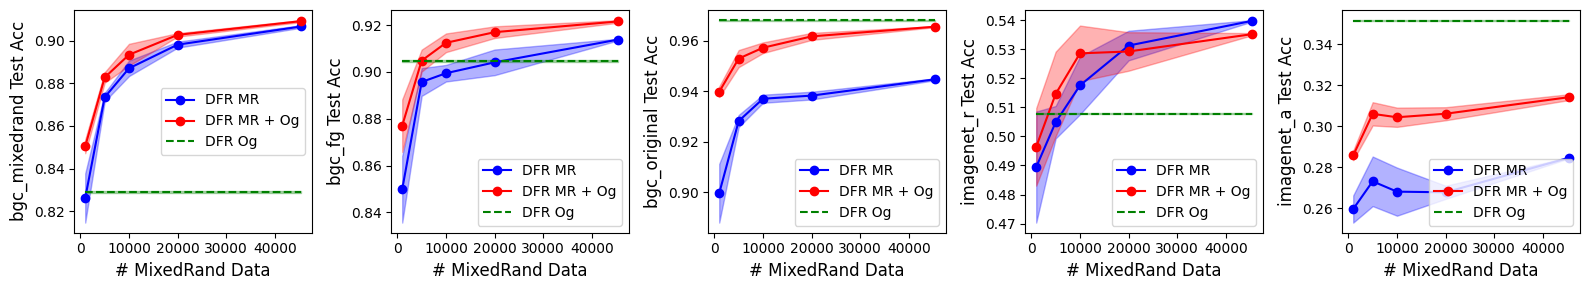

In [ ]:
plot_all_results_indv(mixrand_results_ns_pre, combo_results_ns_pre, results_original_pre)

## Post Projection

In [ ]:
use_ph = True

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/ph_imagenet-r_{use_ph}_val_standardSL_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/ph_imagenet-a_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/jennyni/datasets/original/ph_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/ph_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [ ]:
_, results_original_post = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_post)

-------------------
imagenet_r: 0.510±0.000
imagenet_a: 0.361±0.000
bgc_original: 0.967±0.000
bgc_fg: 0.897±0.000
bgc_mixedrand: 0.806±0.000
train: 0.978±0.000
-------------------
-------------------
imagenet_r: 0.447±0.025
imagenet_a: 0.273±0.016
bgc_original: 0.890±0.009
bgc_fg: 0.839±0.007
bgc_mixedrand: 0.792±0.004
train: 0.952±0.007
-------------------
-------------------
imagenet_r: 0.490±0.007
imagenet_a: 0.283±0.009
bgc_original: 0.927±0.004
bgc_fg: 0.877±0.006
bgc_mixedrand: 0.847±0.003
train: 0.836±0.003
-------------------
-------------------
imagenet_r: 0.497±0.009
imagenet_a: 0.288±0.002
bgc_original: 0.934±0.002
bgc_fg: 0.889±0.003
bgc_mixedrand: 0.862±0.001
train: 0.819±0.002
-------------------
-------------------
imagenet_r: 0.503±0.004
imagenet_a: 0.290±0.005
bgc_original: 0.941±0.002
bgc_fg: 0.893±0.002
bgc_mixedrand: 0.868±0.003
train: 0.813±0.002
-------------------
-------------------
imagenet_r: 0.507±0.000
imagenet_a: 0.288±0.000
bgc_original: 0.943±0.000
bgc_fg

In [ ]:

mixrand_results_ns_post = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_post = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

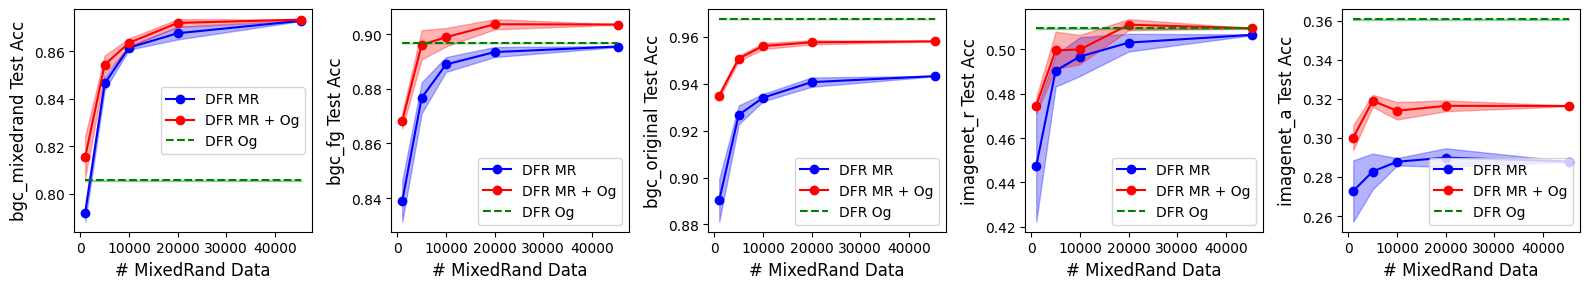

In [ ]:
plot_all_results_indv(mixrand_results_ns_post, combo_results_ns_post, results_original_post)

## Out of Distribution Accuracy vs In Distribution Accuracy 

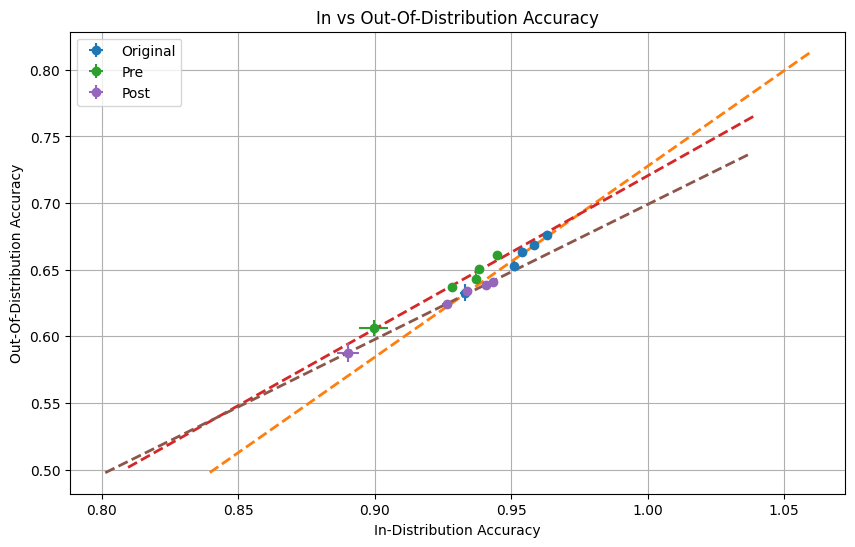

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def process_results(results):
    in_distrib_acc = []
    out_distrib_acc = []
    in_distrib_std = []
    out_distrib_std = []
    
    for res in results:
        in_distrib_acc.append(res['bgc_original'][0])
        in_distrib_std.append(res['bgc_original'][1])
        
        out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        
        out_distrib_acc.append(np.mean(out_distrib_means))
        out_distrib_std.append(np.sqrt(np.mean(np.array(out_distrib_stds) ** 2)))  # Pooled standard deviation
        
    return in_distrib_acc, out_distrib_acc, in_distrib_std, out_distrib_std

in_original, out_original, in_std_original, out_std_original = process_results(mixrand_results_ns_ori)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(mixrand_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(mixrand_results_ns_post)

def plot_results(in_acc, out_acc, in_std, out_std, label, n=5):
    in_err = np.array(in_std) / np.sqrt(n)
    out_err = np.array(out_std) / np.sqrt(n)

    plt.errorbar(in_acc, out_acc, xerr=in_err, yerr=out_err, fmt='o', label=label)
    
    # Using polyfit to fit a 1-degree polynomial (a line) to the points
    slope, intercept = np.polyfit(in_acc, out_acc, 1)
    
    # Creating a range of x values for the line
    min_x = min(in_acc) - 0.1 * abs(min(in_acc))
    max_x = max(in_acc) + 0.1 * abs(max(in_acc))
    in_acc_line = np.linspace(min_x, max_x, 1000)
    out_acc_line = slope * in_acc_line + intercept
    
    plt.plot(in_acc_line, out_acc_line, '--', lw=2) 

# Plotting without the shaded region
plt.figure(figsize=(10,6))
plot_results(in_original, out_original, in_std_original, out_std_original, 'Original')
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre')
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post')

plt.xlabel('In-Distribution Accuracy')
plt.ylabel('Out-Of-Distribution Accuracy')
plt.title('In vs Out-Of-Distribution Accuracy')
plt.legend()
plt.grid(True)
plt.show()


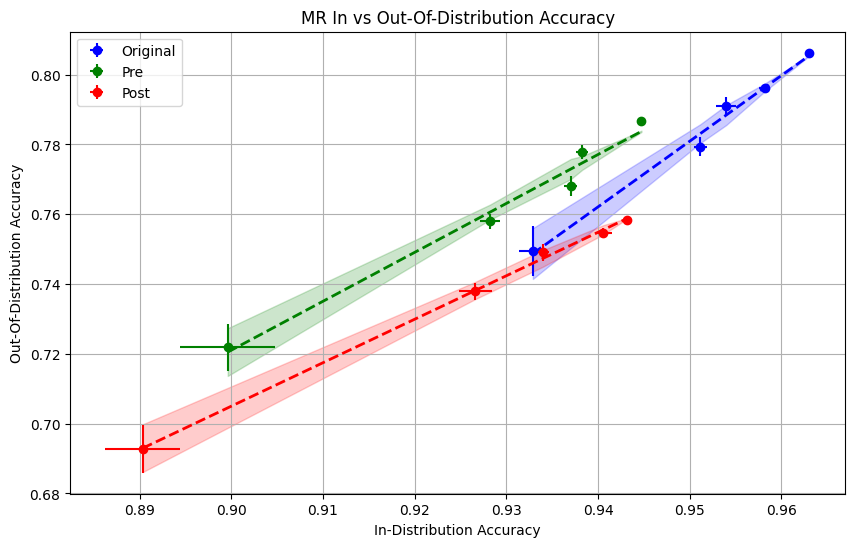

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def process_results(results):
    in_distrib_acc = []
    out_distrib_acc = []
    in_distrib_std = []
    out_distrib_std = []
    
    for res in results:
        in_distrib_acc.append(res['bgc_original'][0])
        in_distrib_std.append(res['bgc_original'][1])
        
        out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train' and k != 'imagenet_a']
        out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train' and k != 'imagenet_a']
        
        out_distrib_acc.append(np.mean(out_distrib_means))
        out_distrib_std.append(np.sqrt(np.mean(np.array(out_distrib_stds) ** 2)))  # Pooled standard deviation
        
    return in_distrib_acc, out_distrib_acc, in_distrib_std, out_distrib_std

# in_original, out_original, in_std_original, out_std_original = process_results(mixrand_results_ns_ori)
# in_pre, out_pre, in_std_pre, out_std_pre = process_results(mixrand_results_ns_pre)
# in_post, out_post, in_std_post, out_std_post = process_results(mixrand_results_ns_post)

def plot_results(in_acc, out_acc, in_std, out_std, label, color, n=5):
    in_err = np.array(in_std) / np.sqrt(n)
    out_err = np.array(out_std) / np.sqrt(n)

    plt.errorbar(in_acc, out_acc, xerr=in_err, yerr=out_err, fmt='o', label=label, color=color)
    slope, intercept, _, _, _ = stats.linregress(in_acc, out_acc)
    in_acc_line = np.array(in_acc)
    out_acc_line = slope * in_acc_line + intercept
    
    plt.plot(in_acc_line, out_acc_line, '--', lw=2, color=color) 
    plt.fill_between(in_acc_line, out_acc_line - out_err, out_acc_line + out_err, alpha=0.2, color=color)

in_original, out_original, in_std_original, out_std_original = process_results(mixrand_results_ns_ori)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(mixrand_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(mixrand_results_ns_post)

plt.figure(figsize=(10,6))
plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue')
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre', 'green')
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post', 'red')

plt.xlabel('In-Distribution Accuracy')
plt.ylabel('Out-Of-Distribution Accuracy')
plt.title('MR In vs Out-Of-Distribution Accuracy')
plt.legend()
plt.grid(True)
plt.show()


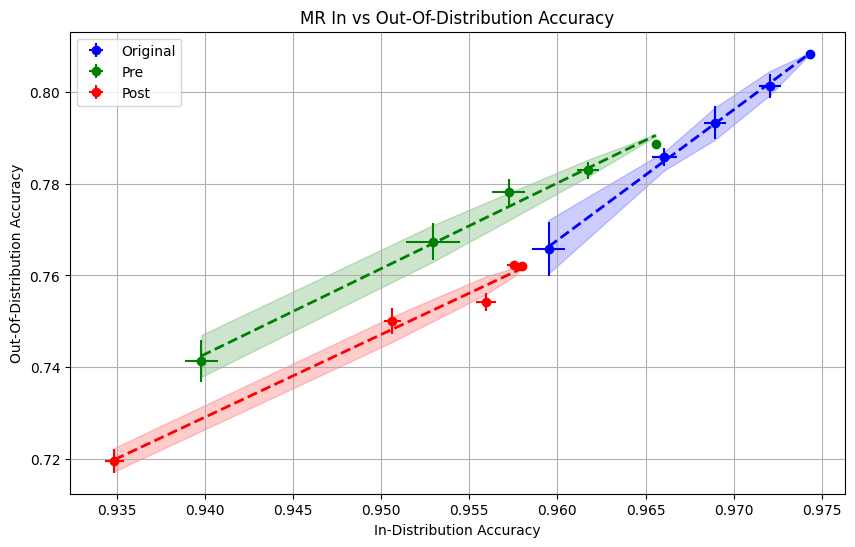

In [ ]:
in_original, out_original, in_std_original, out_std_original = process_results(combo_results_ns_ori)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(combo_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(combo_results_ns_post)
    
plt.figure(figsize=(10,6))
plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue')
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre', 'green')
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post', 'red')

plt.xlabel('In-Distribution Accuracy')
plt.ylabel('Out-Of-Distribution Accuracy')
plt.title('MR In vs Out-Of-Distribution Accuracy')
plt.legend()
plt.grid(True)
plt.show()
